## 产品评论观点提取——数据来源和背景
随着互联网的不断深入普及，越来越多的用户在体验企业提供的产品和服务时，会将其感受和评论分享在互联网上。这些评价和反馈信息对企业针对性地改善产品和服务有极强的指导意义，但互联网的海量信息容量让人工查找并处理评价内容的方案代价高昂。本赛题提供了一个银行业产品评价的场景，探索利用自然语言处理技术来完成评论观点的自动化提取，为行业的进一步发展提高提供参考。

### 相关说明
BIO_anno列：
* B-BANK 代表银行实体的开始
* I-BANK 代表银行实体的内部
* B-PRODUCT 代表产品实体的开始
* I-PRODUCT 代表产品实体的内部
* O 代表不属于标注的范围
* B-COMMENTS_N 代表用户评论（名词）
* I-COMMENTS_N 代表用户评论（名词）实体的内部
* B-COMMENTS_ADJ 代表用户评论（形容词）
* I-COMMENTS_ADJ 代表用户评论（形容词）实体的内部


class列：
* 0 代表情感负面
* 1 代表情感正面
* 2 代表情感中性

## 导入相关模块

In [1]:
TRAIN_PATH = '/project1/liqingshan/NLP/NER/Data/train_data_public.csv'

import pandas as pd
import matplotlib.pyplot as plt

## 查看数据

In [2]:
raw_data = pd.read_csv(TRAIN_PATH)
raw_data

,id,text,BIO_anno,class
0,0,交行14年用过，半年准备提额，却直接被降到1Ｋ，半年期间只T过一次三千，其它全部真实消费，第...,B-BANK I-BANK O O O O O O O O O O B-COMMENTS_N...,0
1,1,单标我有了，最近visa双标返现活动好,B-PRODUCT I-PRODUCT O O O O O O B-PRODUCT I-PR...,1
2,2,建设银行提额很慢的……,B-BANK I-BANK I-BANK I-BANK B-COMMENTS_N I-COM...,0
3,3,我的怎么显示0.25费率，而且不管分多少期都一样费率，可惜只有69k,O O O O O O O O O O B-COMMENTS_N I-COMMENTS_N ...,2
4,4,利率不错，可以撸,B-COMMENTS_N I-COMMENTS_N B-COMMENTS_ADJ I-COM...,1
...,...,...,...,...
7523,7523,我鼎级拒了,O O O B-COMMENTS_ADJ O,2
7524,7524,一打一个准，准胜，看激活信用卡时那协议，全是对银行有利的,O O O O O O O O O O B-COMMENTS_N I-COMMENTS_N ...,2
7525,7525,招行分期白80k,B-BANK I-BANK B-PRODUCT I-PRODUCT I-PRODUCT O O O,2
7526,7526,5万，额度还行吧没毕业哦,O O O B-COMMENTS_N I-COMMENTS_N O O O O O O O,2


## 划分数据集
按照 8:2 的比例划分训练集和测试集。为了尽可能的利用训练集，我们在训练集上做5折交叉验证。

In [3]:
train_data = raw_data[len(raw_data)//5:].reset_index()
test_data = raw_data[:len(raw_data)//5].reset_index()
print(len(train_data), len(test_data))

6023 1505


## 保存训练集和测试集

In [4]:
train_path = '/project1/liqingshan/NLP/NER/Data/train.csv'
train_data.to_csv(train_path)
test_path = '/project1/liqingshan/NLP/NER/Data/test.csv'
test_data.to_csv(test_path)

## 查看文本长度分布

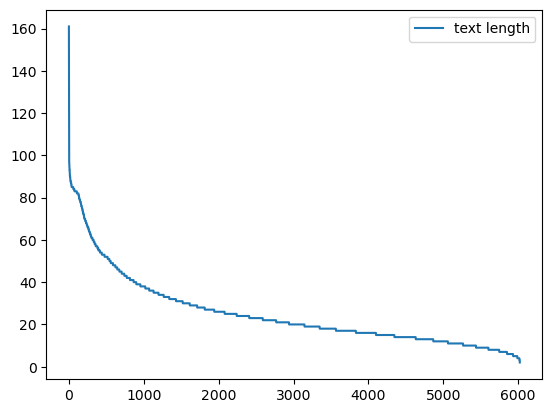

longest text: 4月份提固定额度，同时给临时额度，一直续期，期间分了2次分期，打5折和3.2折的，6.27临时到期不给续，以为要完蛋了，昨晚无意点了一下额度看看，发现又有临时83000，之前是93000，时间到7.27，然后想等明天再看看时间是否能延长，今天再看还是只能到7.27，临时额度却变成108000了，意外。小招又送临时额度了。
longest text length: 161


In [5]:
def get_text_len(data):
    lens = {}
    for i in range(len(data)):
        lens[i] = len(data['text'][i])
    return dict(sorted(lens.items(), key=lambda x:x[1], reverse=True))
text_len_ordered = get_text_len(train_data)

def plot_distribution(data, label):
    '''
    data: dictionary
    label: legend
    '''
    xx = range(len(data))
    plt.plot(xx, data.values(), label=label)
    plt.legend()
    plt.show()
plot_distribution(text_len_ordered, 'text length')
print('longest text:', train_data['text'][next(iter(text_len_ordered.keys()))])
print('longest text length:', next(iter(text_len_ordered.values())))


最长仅161个字符，可以考虑 lstm+crf 和 bert 系列预训练模型。

## 查看词汇分布

total number of different chars = 1970


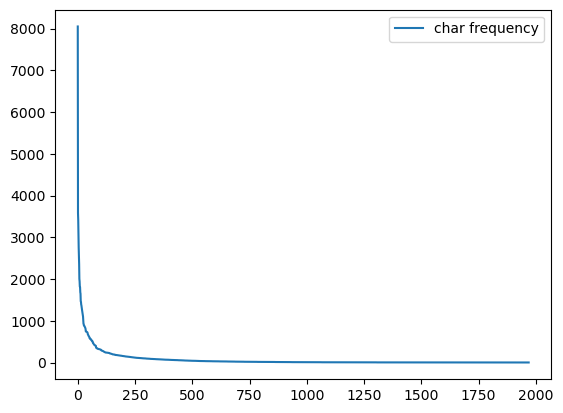

In [6]:
def get_char_freq(data):
    chars = {}
    for i in range(len(data)):
        cur_text = list(data['text'][i])
        for char in cur_text:
            chars[char] = chars.get(char, 0) + 1
    return dict(sorted(chars.items(), key=lambda x:x[1], reverse=True))
char_freq = get_char_freq(train_data)
print(f'total number of different chars = {len(char_freq)}')
plot_distribution(char_freq, 'char frequency')

## 构建词汇表、保存词汇文档
把 PAD 和 UNK 放在词汇表开头。

In [7]:
VOCAB_TXT = '/project1/liqingshan/NLP/NER/Data/vocab.txt'
PAD = '<PAD>'
UNK = '<UNK>'

VOCAB_SIZE = 1970
def save_vocab(char_freq):
    vocab = [PAD, UNK]
    for char in char_freq.keys():
        vocab.append(char)
    vocab_list = vocab[:VOCAB_SIZE]     # 取前1970个词
    vocab_dict = {v:k for k, v in enumerate(vocab_list)}    
    vocab_df = pd.DataFrame(list(vocab_dict.items()), columns=['char', 'id'])
    print(vocab_df)
    vocab_df.to_csv(VOCAB_TXT, header=['char', 'id'], index=None)
    return vocab_dict

vocab_dict = save_vocab(char_freq)

       char    id
0     <PAD>     0
1     <UNK>     1
2         ，     2
3         的     3
4         了     4
...     ...   ...
1965      聽  1965
1966      說  1966
1967      泸  1967
1968      疾  1968
1969      厘  1969

[1970 rows x 2 columns]


## 查看标签分布并构建标签表

[]

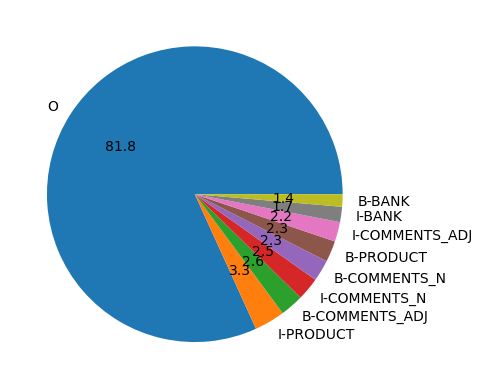

In [8]:
LABEL_TXT = '/project1/liqingshan/NLP/NER/Data/label.txt'

def get_label_freq(data):
    labels = {}
    for i in range(len(data)):
        cur_label = data['BIO_anno'][i].split()
        for label in cur_label:
            labels[label] = labels.get(label, 0) + 1
    return dict(sorted(labels.items(), key=lambda x: x[1], reverse=True))
label_freq = get_label_freq(train_data)

plt.pie(label_freq.values(), labels=label_freq.keys(), autopct='%.1f')
plt.plot()

In [9]:
def save_labels(label_freq):
    label_list = label_freq.keys()
    label_dict = {v:k for k, v in enumerate(label_list)}
    
    label_df = pd.DataFrame(list(label_dict.items()), columns=['label', 'id'])
    print(label_df)
    label_df.to_csv(LABEL_TXT, header=['label', 'id'], index=None)
    return label_dict
label_dict = save_labels(label_freq)

            label  id
0               O   0
1       I-PRODUCT   1
2  B-COMMENTS_ADJ   2
3    I-COMMENTS_N   3
4    B-COMMENTS_N   4
5       B-PRODUCT   5
6  I-COMMENTS_ADJ   6
7          I-BANK   7
8          B-BANK   8
